# Compare adding point methods (Nystrom / modify SVD / split and combine method) using massive data set

## Define functions

### import libraries

In [1]:
%pylab inline
from scipy.io import loadmat
from scipy.spatial.distance import cdist
from scipy.sparse.linalg import svds
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

Populating the interactive namespace from numpy and matplotlib


### plot results

In [2]:
def plotresult(R,C):
    
    fig = plt.figure(figsize=(len(R)*6.8, 6))
    
    j = 1
    for i in R.keys():
        ax = fig.add_subplot(1,len(R),j, projection='3d')
        ax.scatter3D(R[i][:,0],R[i][:,1], R[i][:,2], color=C[i],s=2)
        ax.set_title(i)
        j += 1
        
    plt.show()

### diffusion maps / add points using Nystrom / add points using modify SVD / add points using split and combine method

In [3]:
def MK(X,Y,sigma):
    
    dist = cdist(X,Y)

    return exp(-dist**2/sigma)

In [4]:
def DM(X,sigma,dim=6):
    
    n = X.shape[0]
    
    K = MK(X,X,sigma)
    D = diag(1/sqrt(sum(K,axis=1)))
    A = D.dot(K).dot(D)
    
    U,S,V = svds(A,dim)
    
    S = S[::-1]
    U = U[:,::-1]
    for i in range(dim):
        if U[0,i]<0:
            U[:,i] = -U[:,i]
                        
    emb = D.dot(U).dot(diag(S))
        
    return emb, S, U, diag(D)

In [5]:
def nystrom(EMB,EIG,X,Z,sigma):
    
    ### construct K
    Kadd = MK(Z,X,sigma)
    
    ### construct D
    Dadd = diag(1/sum(Kadd,axis=1))

    ### extension
    EMBadd = Dadd.dot(Kadd).dot(EMB).dot(diag(1/EIG))
    EMBext = vstack((EMB,EMBadd)) 
    
    return EMBext

In [6]:
def modiSVD(EMB,EIG,X,Z,sigma, U,D,dim=6):
        
    ### compute the added rows of random walk matrix
    n = X.shape[0]
    r = Z.shape[0]
    
    ### construct K
    Ksm = MK(Z,X,sigma)
        
    ### construct D
    tmp0 = 1/sqrt(sum(Ksm,axis=1))
    tmp0 = hstack((D,tmp0))
    Dsm  = diag(tmp0[n:])
    Dnew = diag(tmp0)
    D    = diag(tmp0[:n])
    
    ### matrix Q
    Qnew = Dsm.dot(Ksm).dot(D)
            
    ### compute the SVD of the new matrix
    V = U
    S = diag(EIG)
    Z = Qnew.dot(V)
    K = vstack((S,Z))
        
    ### SVD of K
    UK,SK,VK = svd(K,full_matrices=0)
    
    ### new eigenvalue and right eigenvector
    Lnew = diag(SK**2)
    
    tmp1 = U.dot(UK[:dim,:])
    tmp2 = vstack((tmp1, UK[dim:,:]))

    EMBnew = Dnew.dot(tmp2).dot(Lnew)
        
    return EMBnew, SK**2

In [7]:
def combine(Y1,Y2,n,r):
    
    a1 = Y1[n-r,:]
    b1 = Y1[-1,:]
    m1 = (a1[0]-b1[0])/(a1[1]-b1[1])
    d1 = sqrt((a1[0]-b1[0])**2 + (a1[1]-b1[1])**2)
    
    a2 = Y2[0,:]
    b2 = Y2[r-1,:]
    m2 = (a2[0]-b2[0])/(a2[1]-b2[1])
    
    angle = math.atan((m1-m2)/(1+m1*m2))
    ang = array([[cos(angle),-sin(angle)],[sin(angle),cos(angle)]])
    
    Y2 = Y2.dot(ang)
    
    a2 = Y2[0,:]
    b2 = Y2[r-1,:]
    d2 = sqrt((a2[0]-b2[0])**2 + (a2[1]-b2[1])**2)
    
    Y2 = Y2/d2*d1
    
    a2 = Y2[0,:]
    b2 = Y2[r-1,:]
        
    Y2[:,0] += a1[0]-a2[0]
    Y2[:,1] += a1[1]-a2[1]
        
    com  = vstack((Y1,Y2[r:,:]))
        
    return com

In [8]:
def kmeans(emb,cluster=5):

    n = emb.shape[0]
    
    kmeans = KMeans(cluster)
    kmeans = kmeans.fit(emb)
    label  = array(kmeans.predict(emb)).reshape(n,1)
    
    cmap = cm.rainbow
    norm = Normalize(1, cluster)
    col  = cmap(norm(label+1)).reshape(n,4)
    
    return col

# setting

X: original data set, size n

Z: add data set,  size m

sigma: scaling parameter

In [9]:
ori = loadmat('Data/Data-swissroll-2000.mat')['A']

In [10]:
n = 1800
m = ori.shape[0]-n

X = ori[:n,:]
Z = ori[n:,:]

number of orignal data points =  1800
number of add data points =  200


/Users/joyax/opt/anaconda3/envs/mine/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  """


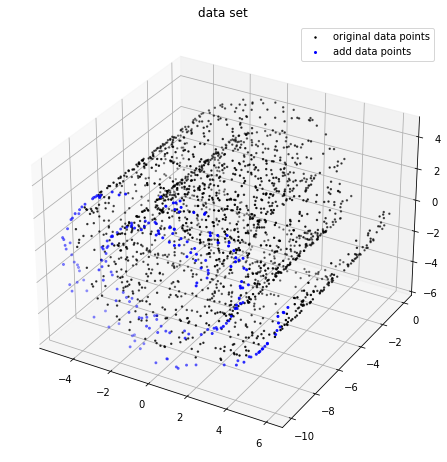

In [11]:
print('number of original data points = ',n)
print('number of added data points = ',m)

fig = plt.figure()
ax  = Axes3D(fig)

ax.scatter(X[:,0],-X[:,1],X[:,2],s=2,c='k',label='original data points')
ax.scatter(Z[:,0],-Z[:,1],Z[:,2],s=4,c='b',label='add data points')

plt.gcf().set_size_inches(8,6)
plt.title('data set')
plt.legend()
plt.show()

## DM of original data set

In [12]:
%%time
sigma = 0.5

EMBdm, EIGdm, U, D = DM(X,sigma)

CPU times: user 5.05 s, sys: 3.01 s, total: 8.06 s
Wall time: 1.14 s


In [13]:
C0 = {}
R0 = {}
tmp  = kmeans(EMBdm[:,1:4])

C0['embedding of X'] = 'k'
C0['clustering of embedding of X'] = tmp
C0['clustering of X'] = tmp

R0['embedding of X'] = EMBdm[:,1:]
R0['clustering of embedding of X'] = EMBdm[:,1:]
R0['clustering of X'] = X

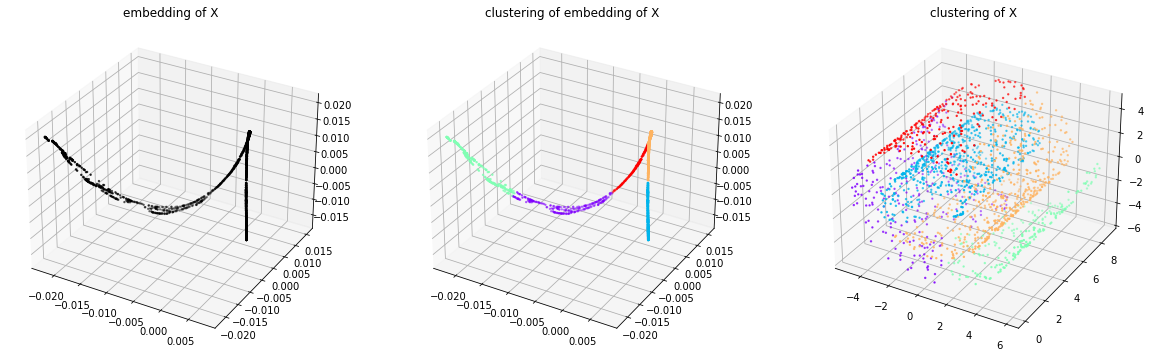

In [14]:
plotresult(R0,C0)

## add points using Nystrom method

In [15]:
%%time
sigma = 0.5

EMBnys = nystrom(EMBdm,EIGdm,X,Z,sigma)

CPU times: user 43 ms, sys: 18.3 ms, total: 61.3 ms
Wall time: 26.2 ms


In [16]:
C1 = {}
R1 = {}
tmp  = kmeans(EMBnys[:,1:4])

C1['embedding of X'] = 'k'
C1['embedding of Z'] = 'b'
C1['clustering of embedding of X+Z'] = tmp
C1['clustering of X+Z'] = tmp

R1['embedding of X'] = EMBnys[:n]
R1['embedding of Z'] = EMBnys[n:]
R1['clustering of embedding of X+Z'] = EMBnys
R1['clustering of X+Z'] = vstack((X,Z))

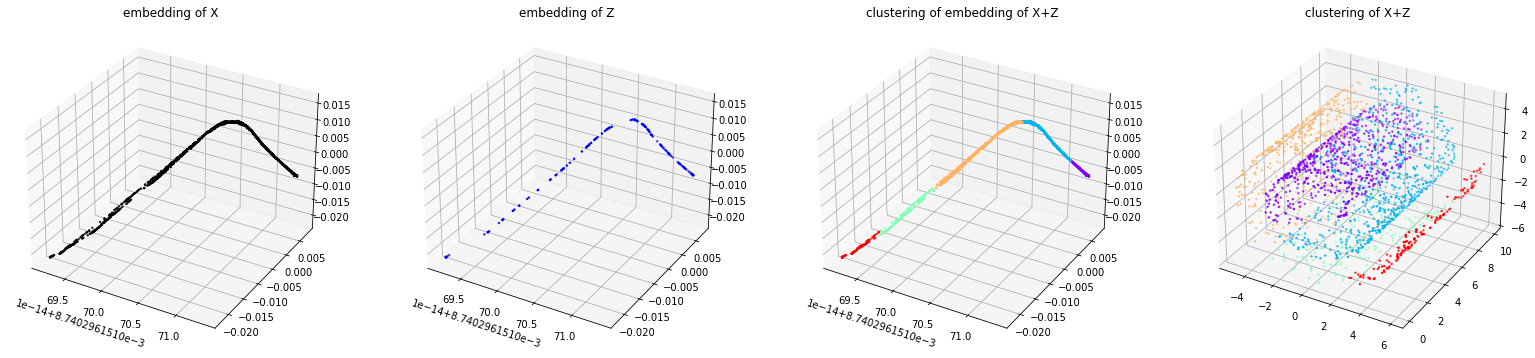

In [17]:
plotresult(R1,C1)

## add points using modify SVD

In [18]:
%%time
sigma = 0.1

EMBmod, EIGmod = modiSVD(EMBdm,EIGdm, X,Z,sigma, U,D)

CPU times: user 229 ms, sys: 61.3 ms, total: 290 ms
Wall time: 63.2 ms


In [19]:
C2 = {}
R2 = {}
tmp  = kmeans(EMBmod[:,1:4])

C2['embedding of X'] = 'k'
C2['embedding of Z'] = 'b'
C2['clustering of embedding of X+Z'] = tmp
C2['clustering of X+Z'] = tmp

R2['embedding of X'] = EMBmod[:n]
R2['embedding of Z'] = EMBmod[n:]
R2['clustering of embedding of X+Z'] = EMBmod
R2['clustering of X+Z'] = vstack((X,Z))

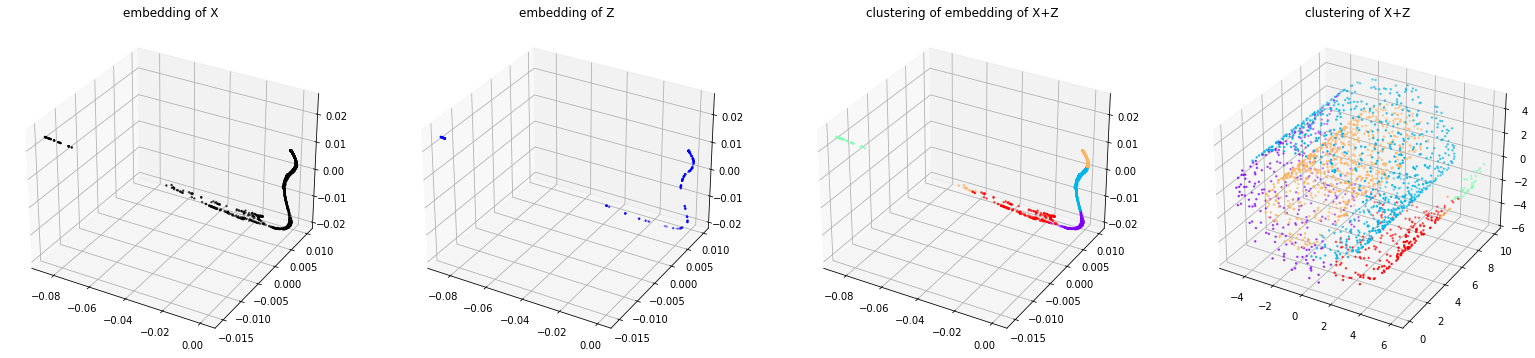

In [20]:
plotresult(R2,C2)

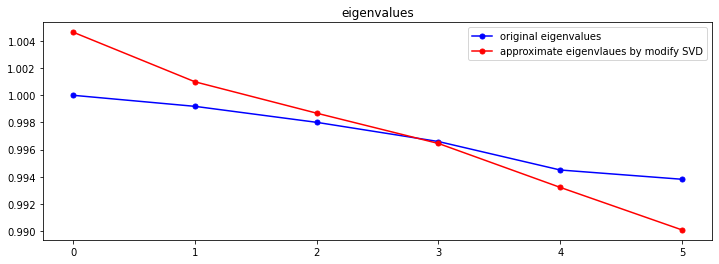

In [21]:
plt.plot(range(6),EIGdm,'b-',marker='.',markersize=10,label='original eigenvalues')
plt.plot(range(6),EIGmod,'r-',marker='.',markersize=10,label='approximate eigenvlaues by modify SVD')
#plt.plot(range(dim),[.8]*dim,'k-')

plt.gcf().set_size_inches(12,4)
plt.title('eigenvalues')
plt.legend()
plt.show()

## add points using split and combine method

In [22]:
%%time
ZZ = ori[(n-m):]
sigma = 0.5

EMBzz,_,_,_ = DM(ZZ,sigma)
EMBsnc = combine(EMBdm[:,1:3],EMBzz[:,1:3],n,m)

CPU times: user 194 ms, sys: 258 ms, total: 452 ms
Wall time: 92.8 ms


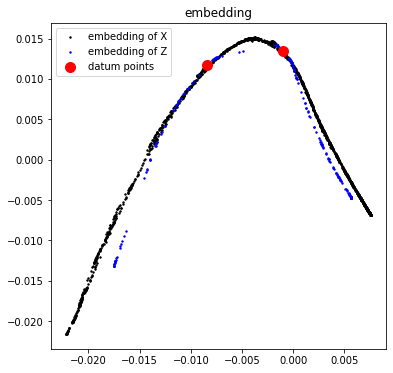

In [24]:
plt.scatter(EMBsnc[:n,0], EMBsnc[:n,1], s=2, c='k',label='embedding of X')
plt.scatter(EMBsnc[n:,0], EMBsnc[n:,1], s=2, c='b',label='embedding of Z')
plt.scatter([EMBsnc[n-m,0],EMBsnc[n-1,0]], [EMBsnc[n-m,1],EMBsnc[n-1,1]], s=100, c='r',label='datum points')

plt.gcf().set_size_inches(6,6)
plt.title('embedding')
plt.legend()
plt.show()

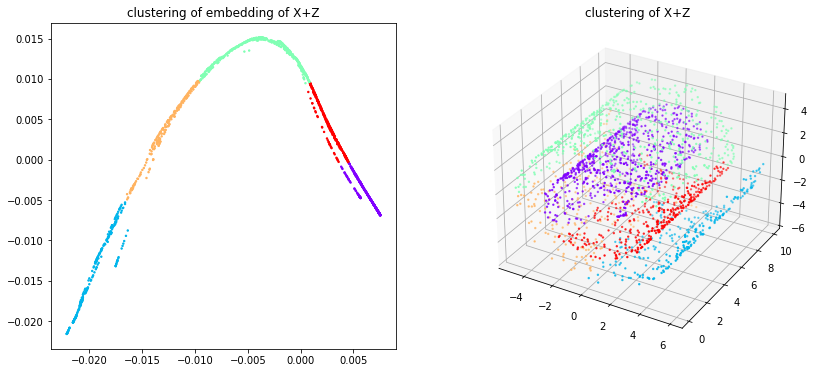

In [25]:
tmp = kmeans(EMBsnc)
tmp2 = vstack((X,Z))

fig = plt.figure(figsize=(2*6.8, 6))

ax1 = fig.add_subplot(121)
ax1.scatter(EMBsnc[:,0],EMBsnc[:,1],color=tmp,s=2)
ax1.set_title('clustering of embedding of X+Z')

ax2 = fig.add_subplot(122,projection='3d')
ax2.scatter3D(tmp2[:,0],tmp2[:,1],tmp2[:,2],color=tmp,s=2)
ax2.set_title('clustering of X+Z')

plt.show()